<a href="https://colab.research.google.com/github/carive47/Finances/blob/main/eda_and_forecast%20/EDA_uniban_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go

In [ ]:
drive.mount('/content/drive')

# 🔹 Cargar el archivo desde la carpeta especificada
file_path = '/content/drive/My Drive/Tablas_Consolidadas_V2/consolidado_POMA_V4.xlsx'
df = pd.read_excel(file_path)

# 🔹 Mostrar información general del DataFrame
print("\n📌 Información general del DataFrame:")
df.info()

# 🔹 Mostrar los primeros registros
print("\n🔍 Primeras filas del DataFrame:")
display(df.head())

Mounted at /content/drive

📌 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_produccion         1555 non-null   int64         
 1   id_finca              1555 non-null   int64         
 2   fecha                 1547 non-null   datetime64[ns]
 3   semana                1547 non-null   float64       
 4   codigo_producto       1047 non-null   float64       
 5   color_embolsados      833 non-null    object        
 6   racimos_embolsados    878 non-null    object        
 7   color_novedades       225 non-null    object        
 8   novedades_al_embolse  280 non-null    float64       
 9   cajas_enviadas        1154 non-null   float64       
 10  color_cosechados      910 non-null    object        
 11  racimos_cosechados    1044 non-null   float64       
 12  racimos_rech

id_produccion  id_finca      fecha  semana  codigo_producto  \
0              1     48128 2025-03-27    13.0           1788.0   
1              2     48128 2025-03-27    13.0              NaN   
2              3     48128 2025-03-27    13.0              NaN   
3              4     48128 2025-03-27    13.0              NaN   
4              5     48128 2025-03-27    13.0              NaN   

  color_embolsados racimos_embolsados color_novedades  novedades_al_embolse  \
0             cafe                219             NaN                   NaN   
1            negro                620             NaN                   NaN   
2          naranja                553             NaN                   NaN   
3            verde                544             NaN                   NaN   
4         amarillo                507             NaN                   NaN   

   cajas_enviadas color_cosechados  racimos_cosechados  racimos_rechazados  \
0           150.0           morado               280.0                72.0   
1             NaN             cafe               340.0                 NaN   
2             NaN              NaN                 NaN                 NaN   
3             NaN              NaN                 NaN                 NaN   
4             NaN              NaN                 NaN                 NaN   

   semana_estimada  cajas_estimadas transportador placa  
0             15.0            150.0           NaN   NaN  
1              NaN              NaN           NaN   NaN  
2              NaN              NaN           NaN   NaN  
3              NaN              NaN           NaN   NaN  
4              NaN              NaN           NaN   NaN

In [ ]:

# --- Calcular Datos Faltantes ---

# 1. Crear una copia temporal para el análisis
df_analisis_faltantes = df.copy()

# 2.  Considerar strings vacíos ('') como valores faltantes
#
df_analisis_faltantes.replace('', np.nan, inplace=True)
#  otros strings si también representan faltantes:
# df_analisis_faltantes.replace(['', ' ', 'N/A', 'No Registra'], np.nan, inplace=True)

# 3. Calcular el número total de valores nulos (NaN) por columna
missing_counts = df_analisis_faltantes.isnull().sum()

# 4. Calcular el número total de filas para el porcentaje
total_rows = len(df_analisis_faltantes)

# 5. Calcular el porcentaje de valores nulos por columna
missing_percentages = (missing_counts / total_rows) * 100

# 6. Crear un DataFrame resumen para mostrar los resultados
missing_summary = pd.DataFrame({
    'Variable': missing_counts.index,
    'Cantidad Faltante': missing_counts.values,
    'Porcentaje Faltante (%)': missing_percentages.values
})

# 7. Ordenar el resumen por cantidad (o porcentaje) descendente

missing_summary.sort_values(by='Cantidad Faltante', ascending=False, inplace=True)

# 8. Formatear el porcentaje para que sea más legible
missing_summary['Porcentaje Faltante (%)'] = missing_summary['Porcentaje Faltante (%)'].round(2)

# --- Mostrar Resultados ---

print("\nResumen de Datos Faltantes Originales:")
# Filtrar para mostrar solo las columnas que SÍ tienen datos faltantes
missing_summary_filtered = missing_summary[missing_summary['Cantidad Faltante'] > 0]

if missing_summary_filtered.empty:
    print("\n¡Excelente! No se encontraron datos faltantes (NaN o '') en el DataFrame original.")
else:
    # Usar .to_string() para asegurar que se muestren todas las filas si son muchas
    print(missing_summary_filtered.to_string(index=False))


--- Analizando Datos Faltantes en el DataFrame ORIGINAL (`df_original`) ---

Resumen de Datos Faltantes Originales:
            Variable  Cantidad Faltante  Porcentaje Faltante (%)
               placa               1454                    93.50
     color_novedades               1330                    85.53
novedades_al_embolse               1275                    81.99
  racimos_rechazados               1270                    81.67
     semana_estimada               1015                    65.27
     cajas_estimadas               1011                    65.02
    color_embolsados                722                    46.43
  racimos_embolsados                677                    43.54
    color_cosechados                645                    41.48
  racimos_cosechados                511                    32.86
     codigo_producto                508                    32.67
      cajas_enviadas                401                    25.79
       transportador                389

In [ ]:

def corregir_y_mejorar_formatos_v2(df_or):
    """
    Corrige formatos de columna completa y maneja NaNs específicamente,
    aplicando lógica de relleno/derivación SOLO a los valores NaN originales.

    - Conversiones de TIPO (Int64, category, datetime) se aplican a toda la columna.
    - Lógica de RELLENO/IMPUTACIÓN/DERIVACIÓN solo afecta a celdas originalmente NaN.

    Imputaciones:
    - Pone NaN con 0 en 'novedades_al_embolse' y 'racimos_rechazados'.
    - Pone NaN en 'racimos_embolsados', 'racimos_cosechados', 'cajas_enviadas'
      con la mediana (Placeholder para imputación avanzada).
    - Rellena NaN en 'color_embolsados' usando 'semana' y calendario.
    """
    df = df_or.copy()

    # --- Pre-procesamiento: Estandarizar Nulos ---
    df.replace({'': np.nan, 'None': np.nan, 'nan':np.nan}, inplace=True)

    # --- 1. Identificar NaNs Originales  ---
    # Guardamos máscaras booleanas para saber qué celdas eran NaN al inicio
    nan_masks = {}
    cols_to_fill = ["novedades_al_embolse", "racimos_rechazados",
                    "racimos_embolsados", "racimos_cosechados", "cajas_enviadas",
                    "color_embolsados"]
    for col in cols_to_fill:
        if col in df.columns:
             # Convertir a tipo numérico/string antes de isnull para consistencia
             if col != "color_embolsados":
                 temp_col = pd.to_numeric(df[col], errors='coerce')
                 nan_masks[col] = temp_col.isnull()
             else:
                 nan_masks[col] = df[col].isnull() | (df[col].astype(str).str.strip() == '') # Incluir strings vacíos

    # --- 2. Aplicar Lógica de Relleno/Derivación SOLO a los NaN Originales ---

    # Rellenar con 0 (SOLO donde era NaN)
    fill_zero_cols = ["novedades_al_embolse", "racimos_rechazados"]
    for col in fill_zero_cols:
        if col in df.columns and nan_masks[col].any():
            # Convertir a numérico antes de rellenar para asegurar que fillna funcione
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.loc[nan_masks[col], col] = 0
            print(f"INFO: {nan_masks[col].sum()} NaN originales en '{col}' rellenados con 0.")

    # Imputación con Mediana
    impute_median_cols = ["racimos_embolsados", "racimos_cosechados", "cajas_enviadas"]
    for col in impute_median_cols:
        if col in df.columns and nan_masks[col].any():
            # Convertir a numérico ANTES de calcular mediana y rellenar
            df[col] = pd.to_numeric(df[col], errors='coerce')
            median_val = df[col].median()
            df.loc[nan_masks[col], col] = median_val
            print(f"INFO: {nan_masks[col].sum()} NaN originales en '{col}' rellenados con la mediana ({median_val}).")

    # Derivación de 'color_embolsados' (SOLO donde era NaN)
    col = 'color_embolsados'
    if col in df.columns and nan_masks[col].any():
        print(f"INFO: Intentando rellenar {nan_masks[col].sum()} NaN originales en '{col}' usando calendario...")
        # Calcular semana_embolse (necesario para la derivación)
        # Asegurar que 'semana' sea numérico primero
        df["semana_numeric"] = pd.to_numeric(df["semana"], errors='coerce')
        df["semana_embolse"] = df["semana_numeric"].astype(float) - 10

        colores_base = ['DORADO', 'GRIS', 'MORADO', 'CAFÉ', 'NEGRO', 'NARANJA',
                        'VERDE', 'AMARILLO', 'BLANCO', 'AZUL']

        def get_color_from_week(semana_emb):
            if pd.isna(semana_emb): return "desconocido"
            try:
                indice = int(semana_emb - 1) % 10
                return colores_base[indice]
            except Exception: return "error_calculo"

        # Calcular colores derivados SOLO para las filas donde el color original era NaN
        # Aplicar la función a la columna 'semana_embolse' filtrada por la máscara
        derived_colors = df.loc[nan_masks[col], 'semana_embolse'].apply(get_color_from_week)

        # Asignar los colores derivados ÚNICAMENTE a las celdas que originalmente eran NaN
        df.loc[nan_masks[col], col] = derived_colors

        # Limpiar columnas temporales
        df.drop(columns=['semana_numeric', 'semana_embolse'], inplace=True, errors='ignore')


    # --- 3. Aplicar Conversiones de TIPO a Columnas COMPLETAS ---

    # Fecha (toda la columna)
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

    # IDs a Int64 (toda la columna)
    id_columns = ["id_produccion", "id_finca"]
    for col in id_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    # Convertir a Int64 las columnas numéricas (enteras)
    # Asegurar conversión numérica previa por si acaso
    int_cols_final = ["semana", # Convertir semana ahora
                      "novedades_al_embolse", "racimos_rechazados",
                      "racimos_embolsados", "racimos_cosechados",
                      "cajas_enviadas", "cajas_estimadas"]
    for col in int_cols_final:
         if col in df.columns:
            numeric_col = pd.to_numeric(df[col], errors='coerce')
            try:
                 # Intentar Int64 directamente
                 df[col] = numeric_col.astype("Int64")
            except TypeError:
                 # Si falla (p.ej. por floats de la mediana), redondear y intentar de nuevo O dejar como float
                 try:
                     print(f"WARN: Intentando redondear y convertir '{col}' a Int64.")
                     df[col] = numeric_col.round().astype("Int64")
                 except Exception as e:
                      print(f"ERROR: No se pudo convertir '{col}' a Int64 incluso redondeando: {e}. Se mantiene como float.")
                      df[col] = numeric_col # Mantener como float si todo falla

    # Convertir a Categoría (columnas completas)
    categorical_cols = ["id_finca","codigo_producto", "color_embolsados", "color_novedades",
                        "color_cosechados", "transportador", "placa",
                        "semana_estimada"]

    for col in categorical_cols:
         if col in df.columns:
            # Convertir a string primero puede ayudar a unificar tipos antes de categorizar
            df[col] = df[col].astype(str)
            # Reemplazar 'nan' literal (resultado de astype(str)) con un valor manejable
            df[col].replace({'nan': 'desconocido', 'None':'desconocido'}, inplace=True)

            df[col] = df[col].astype("category")

            # Añadir categorías necesarias ('desconocido', 'error_calculo' para color_embolsados)
            cats_to_add = []
            if "desconocido" not in df[col].cat.categories:
                cats_to_add.append("desconocido")
            if col == 'color_embolsados' and "error_calculo" not in df[col].cat.categories:
                cats_to_add.append("error_calculo")

            if cats_to_add:
                df[col] = df[col].cat.add_categories(cats_to_add)

            # Rellenar NaNs que pudieran quedar (aunque el replace anterior debería minimizarlos)
            if df[col].isnull().any():
                 # Verificar si 'desconocido' es una categoría válida antes de rellenar
                 if "desconocido" in df[col].cat.categories:
                     df[col].fillna("desconocido", inplace=True)
                 else:
                      # Si 'desconocido' no está, añadirlo y luego rellenar
                      df[col] = df[col].cat.add_categories(["desconocido"])
                      df[col].fillna("desconocido", inplace=True)

    return df
df_format = corregir_y_mejorar_formatos_v2(df)
display(df_format)
df_format.info()

INFO: 1275 NaN originales en 'novedades_al_embolse' rellenados con 0.
INFO: 1270 NaN originales en 'racimos_rechazados' rellenados con 0.
INFO: 678 NaN originales en 'racimos_embolsados' rellenados con la mediana (150.0).
INFO: 511 NaN originales en 'racimos_cosechados' rellenados con la mediana (123.5).
INFO: 401 NaN originales en 'cajas_enviadas' rellenados con la mediana (39.5).
INFO: Intentando rellenar 722 NaN originales en 'color_embolsados' usando calendario...
WARN: Intentando redondear y convertir 'racimos_cosechados' a Int64.
WARN: Intentando redondear y convertir 'cajas_enviadas' a Int64.


<ipython-input-5-1872714e3456>:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({'nan': 'desconocido', 'None':'desconocido'}, inplace=True)
<ipython-input-5-1872714e3456>:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

id_produccion  id_finca      fecha  semana codigo_producto  \
0                 1     48128 2025-03-27      13          1788.0   
1                 2     48128 2025-03-27      13     desconocido   
2                 3     48128 2025-03-27      13     desconocido   
3                 4     48128 2025-03-27      13     desconocido   
4                 5     48128 2025-03-27      13     desconocido   
...             ...       ...        ...     ...             ...   
1550           1551     46827 2025-03-27      13     desconocido   
1551           1552     46827 2025-03-27      13     desconocido   
1552           1553     46827 2025-03-27      13     desconocido   
1553           1554     46827 2025-03-27      13     desconocido   
1554           1555     46827 2025-03-27      13     desconocido   

     color_embolsados  racimos_embolsados color_novedades  \
0                cafe                 219     desconocido   
1               negro                 620     desconocido   
2             naranja                 553     desconocido   
3               verde                 544     desconocido   
4            amarillo                 507     desconocido   
...               ...                 ...             ...   
1550           MORADO                 150        amarillo   
1551           MORADO                 150          blanco   
1552           MORADO                 150            azul   
1553           MORADO                 150          dorado   
1554           MORADO                 150            gris   

      novedades_al_embolse  cajas_enviadas color_cosechados  \
0                        0             150           morado   
1                        0              40             cafe   
2                        0              40      desconocido   
3                        0              40      desconocido   
4                        0              40      desconocido   
...                    ...             ...              ...   
1550                    74              40      desconocido   
1551                     3              40      desconocido   
1552                   118              40      desconocido   
1553                  1480              40      desconocido   
1554                     4              40      desconocido   

      racimos_cosechados  racimos_rechazados semana_estimada  cajas_estimadas  \
0                    280                  72            15.0              150   
1                    340                   0     desconocido             <NA>   
2                    124                   0     desconocido             <NA>   
3                    124                   0     desconocido             <NA>   
4                    124                   0     desconocido             <NA>   
...                  ...                 ...             ...              ...   
1550                 124                   0     desconocido             <NA>   
1551                 124                   0     desconocido             <NA>   
1552                 124                   0     desconocido             <NA>   
1553                 124                   0     desconocido             <NA>   
1554                 124                   0     desconocido             <NA>   

     transportador        placa  
0      desconocido  desconocido  
1      desconocido  desconocido  
2      desconocido  desconocido  
3      desconocido  desconocido  
4      desconocido  desconocido  
...            ...          ...  
1550  Sergio David  desconocido  
1551  Sergio David  desconocido  
1552  Sergio David  desconocido  
1553  Sergio David  desconocido  
1554  Sergio David  desconocido  

[1555 rows x 17 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_produccion         1555 non-null   Int64         
 1   id_finca              1555 non-null   Int64         
 2   fecha                 1547 non-null   datetime64[ns]
 3   semana                1547 non-null   Int64         
 4   codigo_producto       1555 non-null   category      
 5   color_embolsados      1555 non-null   category      
 6   racimos_embolsados    1555 non-null   Int64         
 7   color_novedades       1555 non-null   category      
 8   novedades_al_embolse  1555 non-null   Int64         
 9   cajas_enviadas        1555 non-null   Int64         
 10  color_cosechados      1555 non-null   category      
 11  racimos_cosechados    1555 non-null   Int64         
 12  racimos_rechazados    1555 non-null   Int64         
 13  semana_estimada   


📊 Resumen estadístico de variables numéricas:


id_produccion      id_finca                          fecha  \
count    1555.000000   1555.000000                           1547   
mean      778.000000  45815.026367  2025-02-17 13:20:31.027795968   
min         1.000000  40301.000000            2023-11-11 00:00:00   
25%       389.500000  44530.000000            2025-01-28 00:00:00   
50%       778.000000  46619.000000            2025-02-24 00:00:00   
75%      1166.500000  47734.000000            2025-03-11 00:00:00   
max      1555.000000  49458.000000            2026-02-18 00:00:00   
std       449.034149   2342.133037                            NaN   

            semana  codigo_producto  novedades_al_embolse  cajas_enviadas  \
count  1547.000000      1047.000000            280.000000     1154.000000   
mean      9.558500       995.209169             16.667857       63.685442   
min       1.000000         0.000000              0.000000        0.000000   
25%       6.000000       299.000000              2.000000       13.000000   
50%       9.000000       579.000000              5.000000       39.500000   
75%      11.000000      1716.000000             10.000000       80.000000   
max      52.000000      1788.000000           1480.000000     1788.000000   
std       8.094664       674.937252             95.002171       96.256401   

       racimos_cosechados  racimos_rechazados  semana_estimada  \
count         1044.000000          285.000000       540.000000   
mean           180.363027           19.266667        10.940741   
min              0.000000            0.000000         2.000000   
25%             38.000000            4.000000         9.000000   
50%            123.500000           10.000000        11.500000   
75%            240.250000           20.000000        14.000000   
max           1254.000000          519.000000        50.000000   
std            196.226305           40.785929         3.655911   

       cajas_estimadas  
count       544.000000  
mean        127.977941  
min           3.000000  
25%          60.000000  
50%         100.000000  
75%         170.000000  
max         730.000000  
std         106.145820

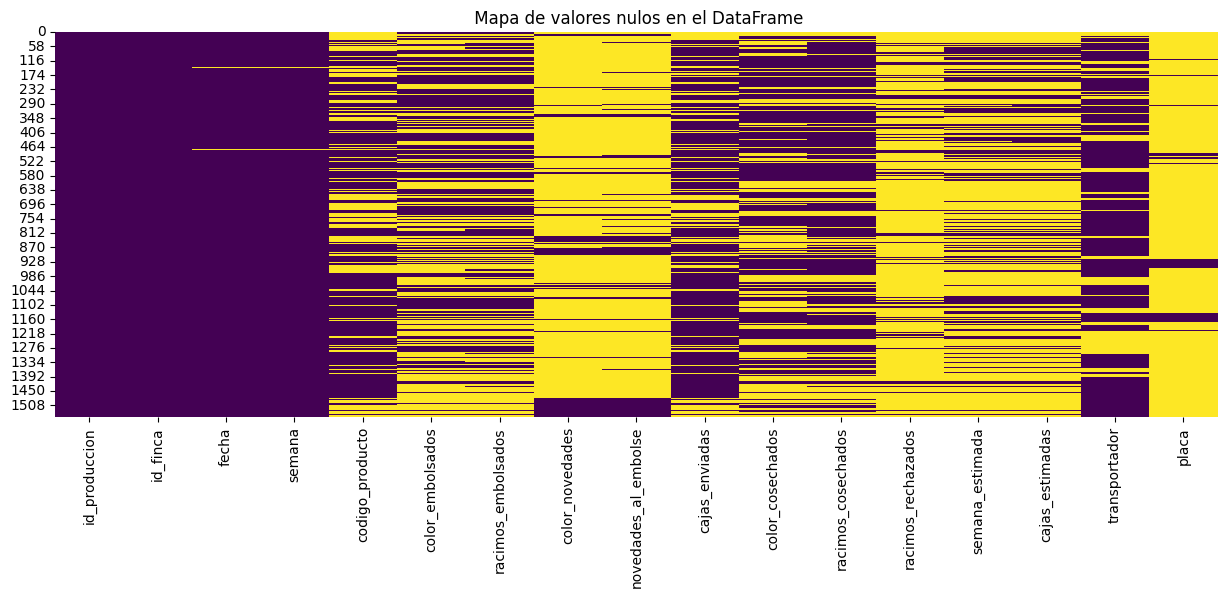

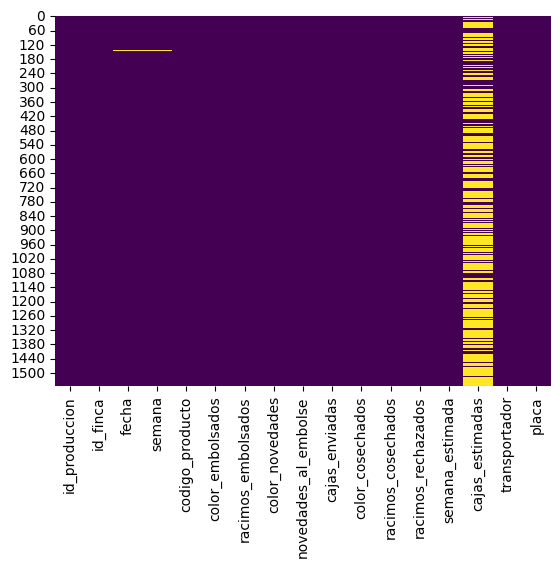

In [ ]:
# 🔹 Resumen estadístico
describe_df = df.describe()
print("\n📊 Resumen estadístico de variables numéricas:")
display(describe_df)

# 🔹 Visualización de valores nulos
plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title(' Mapa de valores nulos en el DataFrame')
plt.show()

sns.heatmap(df_format.isnull(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
df_format.color_embolsados.value_counts()

color_embolsados
GRIS             153
azul             126
dorado           124
blanco           116
MORADO           102
amarillo          99
DORADO            97
verde             84
gris              81
naranja           73
NARANJA           62
BLANCO            59
negro             58
AMARILLO          56
VERDE             49
AZUL              47
NEGRO             47
CAFÉ              46
cafe              34
morado            30
desconocido        4
0                  2
neranja            2
310.0              1
doredo             1
mrado              1
nego               1
error_calculo      0
Name: count, dtype: int64

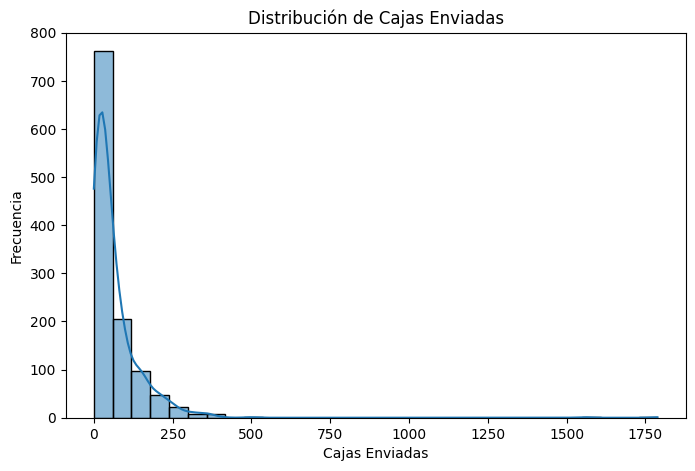

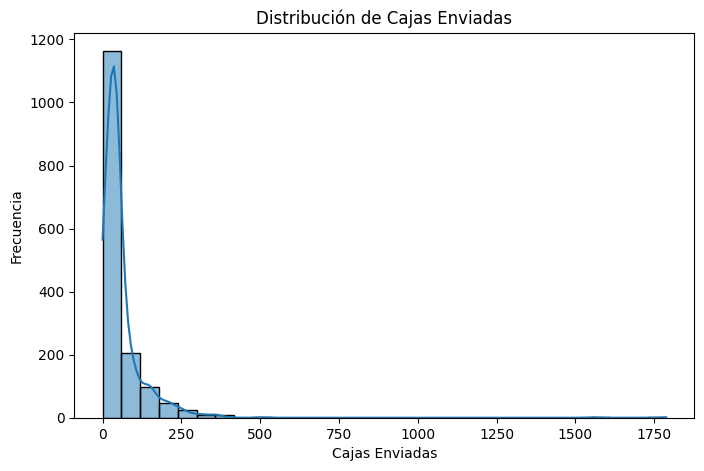

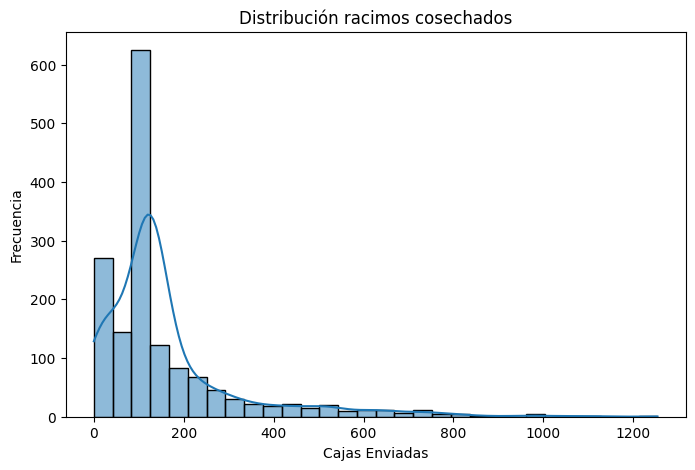

In [ ]:

# 🔹 Distribución
plt.figure(figsize=(8, 5))
sns.histplot(df['cajas_enviadas'].dropna(), bins=30, kde=True)
plt.title('Distribución de Cajas Enviadas')
plt.xlabel('Cajas Enviadas')
plt.ylabel('Frecuencia')
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(df_format['cajas_enviadas'].dropna(), bins=30, kde=True)
plt.title('Distribución de Cajas Enviadas')
plt.xlabel('Cajas Enviadas')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_format['racimos_cosechados'].dropna(), bins=30, kde=True)
plt.title('Distribución racimos cosechados')
plt.xlabel('Cajas Enviadas')
plt.ylabel('Frecuencia')
plt.show()

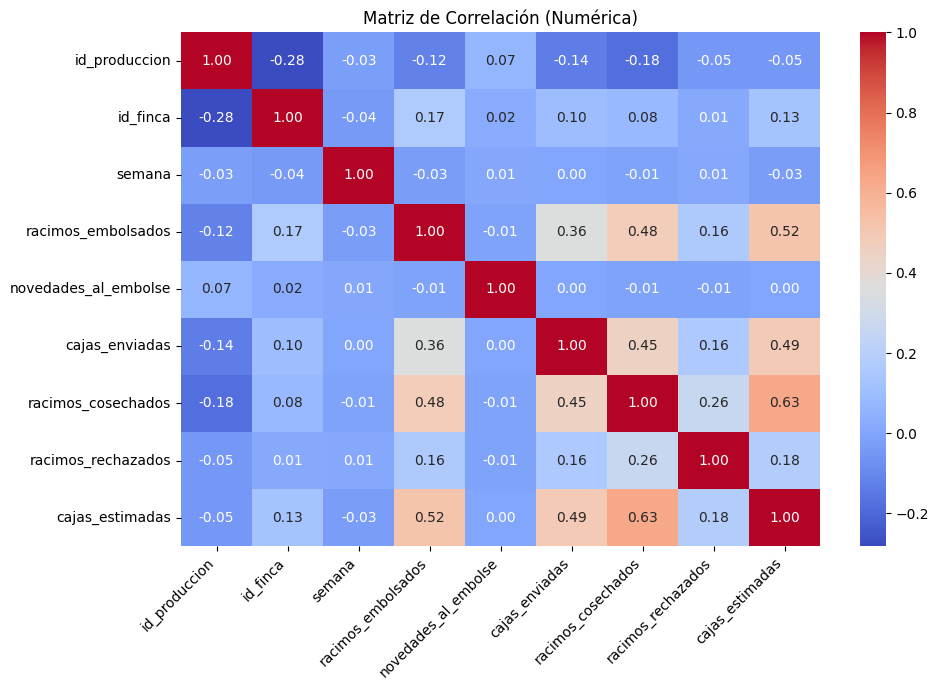

In [ ]:
numeric_df = df_format.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()

#  Graficar el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (Numérica)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Esto mostrará la relación entre cada par de variables numéricas.
Generando pairplot para las columnas: ['racimos_embolsados', 'novedades_al_embolse', 'cajas_enviadas', 'racimos_cosechados', 'racimos_rechazados', 'cajas_estimadas']


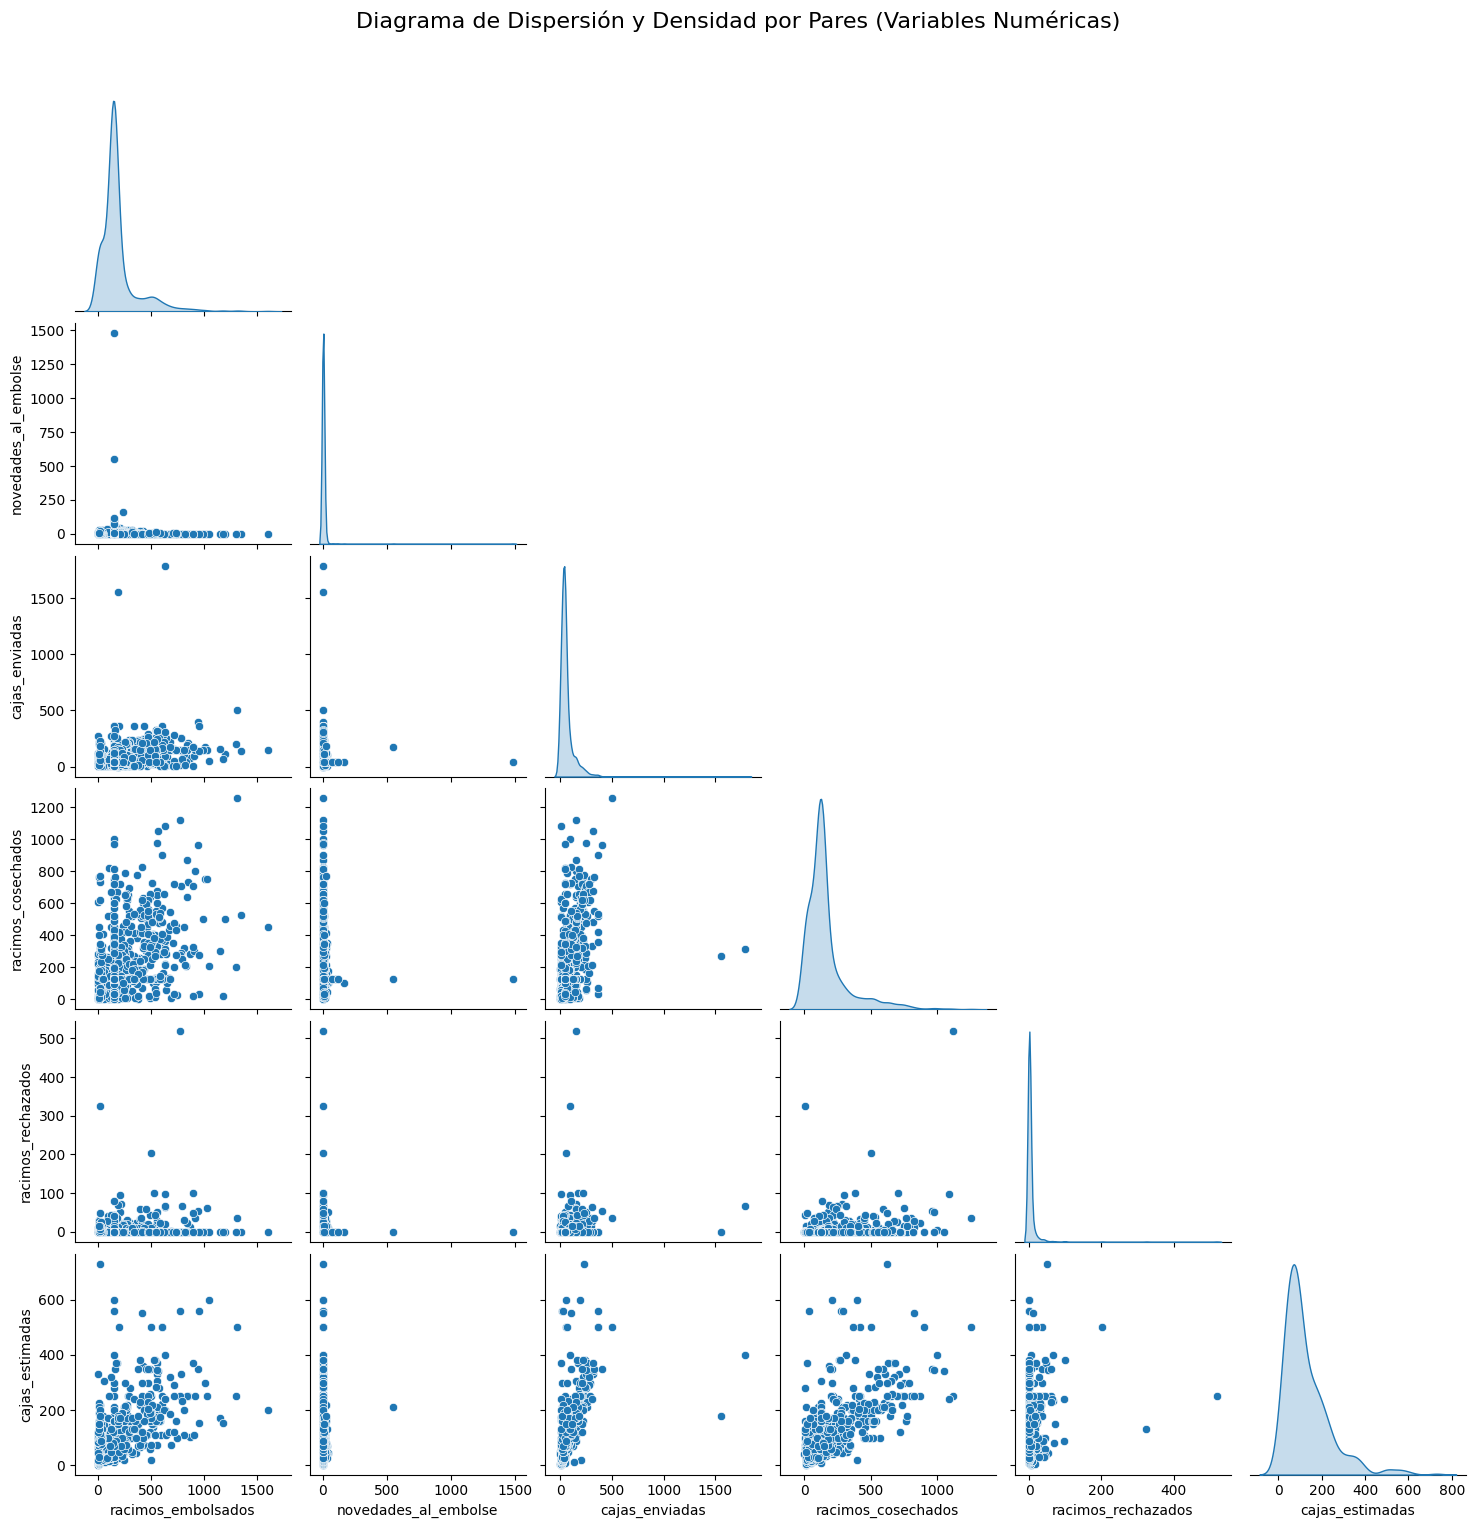

In [ ]:

print("Esto mostrará la relación entre cada par de variables numéricas.")


# --- 1. Seleccionar solo columnas numéricas ---
try:
    numeric_df = df_format[['racimos_embolsados','novedades_al_embolse','cajas_enviadas','racimos_cosechados','racimos_rechazados','cajas_estimadas']]

    if numeric_df.empty:
        print("ADVERTENCIA: No se encontraron columnas numéricas para generar el pairplot.")
    elif len(numeric_df.columns) < 2:
         print("ADVERTENCIA: Se necesita al menos dos columnas numéricas para generar el pairplot.")
    else:
        print(f"Generando pairplot para las columnas: {numeric_df.columns.tolist()}")

        # --- 2. Generar el Pairplot ---
        # sns.pairplot crea una figura con múltiples ejes (una cuadrícula)
        # diag_kind='kde' muestra una estimación de densidad en la diagonal (variable vs sí misma)
        # corner=True muestra solo la mitad inferior de la matriz (evita redundancia)
        pair_plot_fig = sns.pairplot(numeric_df, diag_kind='kde', corner=True) # Pon corner=True si prefieres ver solo la mitad

        # Añadir un título general sobre toda la figura
        pair_plot_fig.fig.suptitle('Diagrama de Dispersión y Densidad por Pares (Variables Numéricas)',
                                   y=1.02, # Ajusta la posición vertical del título si es necesario
                                   fontsize=16)

        # Ajustar un poco el layout puede ayudar
        pair_plot_fig.tight_layout() # A veces interfiere con suptitle

        plt.show()

except Exception as e:
    print(f"ERROR al generar el pairplot: {e}")

In [ ]:

import plotly.express as px

# 🔹 Análisis de la serie temporal de cajas enviadas
df_format['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df_format = df_format.sort_values(by='fecha')

# Crear el gráfico interactivo con Plotly
fig = px.line(df_format.groupby('fecha')['cajas_enviadas'].sum().reset_index(), x='fecha', y='cajas_enviadas',
              title='📦 Evolución Temporal de Cajas Enviadas',
              labels={'fecha': 'Fecha', 'cajas_enviadas': 'Cajas Enviadas'},
              markers=True)

# Mostrar el gráfico
fig.update_traces(line=dict(width=2), marker=dict(size=6))
fig.update_layout(template='plotly_white', showlegend=False)
fig.show()



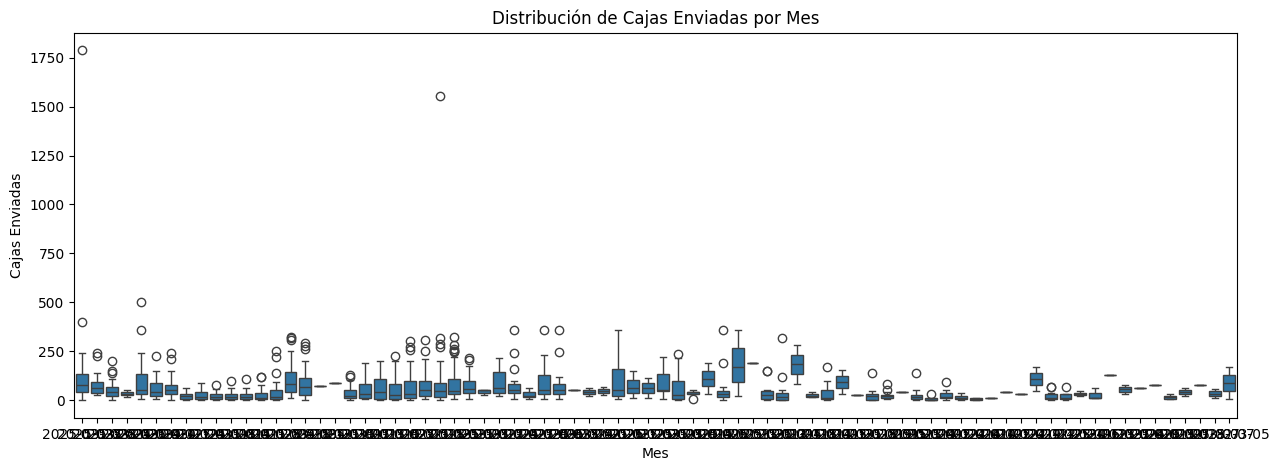

In [ ]:

# 🔹 Análisis de estacionalidad
#df_format['semana'] = df_format['fecha'].dt.month
plt.figure(figsize=(15, 5))
sns.boxplot(x='fecha', y='cajas_enviadas', data=df)
plt.title('Distribución de Cajas Enviadas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cajas Enviadas')
plt.show()

In [ ]:

print("--- Preparando datos de df_format para EDA de Series de Tiempo ---")
# --- 1. Preparar Data ---
df_analysis = df_format[['fecha', 'codigo_producto', 'color_embolsados', 'racimos_cosechados']].copy()
df_analysis['fecha'] = pd.to_datetime(df_analysis['fecha'], errors='coerce')
df_analysis['racimos_cosechados'] = pd.to_numeric(df_analysis['racimos_cosechados'], errors='coerce').astype(float)
df_analysis.dropna(subset=['fecha', 'racimos_cosechados'], inplace=True)
print(f"Filas utilizables para agregación: {len(df_analysis)}")

# --- 2. Aggregate Data ---
print("\n--- Agrupando cosecha por día, producto y color ---")
daily_harvest_df = df_analysis.groupby(
    [df_analysis['fecha'].dt.date, 'codigo_producto', 'color_embolsados'],
    observed=False
)['racimos_cosechados'].sum().reset_index()
daily_harvest_df.rename(columns={'fecha': 'fecha_dia', 'racimos_cosechados': 'total_racimos_cosechados'}, inplace=True)
daily_harvest_df['fecha_dia'] = pd.to_datetime(daily_harvest_df['fecha_dia'])
daily_harvest_df.sort_values(by='fecha_dia', inplace=True)
print("--- Datos Agregados Listos ---")
print(daily_harvest_df.head())

# --- 3. EDA con Plotly Express (Plots seleccionados) ---
if not daily_harvest_df.empty:
    print("\n--- Generando Gráficos Interactivos con Plotly Express (Versión Reducida) ---")

    # --- Plot 1: Cosecha Total Diaria (Matches 4.1) ---
    total_daily = daily_harvest_df.groupby('fecha_dia')['total_racimos_cosechados'].sum().reset_index()
    fig_total = px.line(total_daily, x='fecha_dia', y='total_racimos_cosechados',
                        title='Total Racimos Cosechados por Día')
    fig_total.update_layout(xaxis_title='Fecha', yaxis_title='Total Racimos Cosechados')
    fig_total.show()

    # --- Plot 2: Cosecha por Código de Producto (Matches 4.2) ---
    fig_producto = px.line(daily_harvest_df, x='fecha_dia', y='total_racimos_cosechados',
                            color='codigo_producto',
                            title='Racimos Cosechados por Día y Código de Producto')
    fig_producto.update_layout(xaxis_title='Fecha', yaxis_title='Total Racimos Cosechados')
    fig_producto.show()

    # --- Plot 3: Cosecha por Color de Embolsado (Matches 4.3) ---
    fig_color = px.line(daily_harvest_df, x='fecha_dia', y='total_racimos_cosechados',
                        color='color_embolsados',
                        title='Racimos Cosechados por Día y Color de Embolsado')
    fig_color.update_layout(xaxis_title='Fecha', yaxis_title='Total Racimos Cosechados')
    fig_color.show()

    # --- Plot 4: Descomposición de la Serie de Tiempo (Matches 4.4) ---
    print("\n--- Preparando Descomposición Estacional (Total Diario) ---")
    total_daily_indexed = total_daily.set_index('fecha_dia')

    if not total_daily_indexed.empty:
        date_range = pd.date_range(start=total_daily_indexed.index.min(),
                                  end=total_daily_indexed.index.max(),
                                  freq='D')
        total_daily_dense = total_daily_indexed.reindex(date_range, fill_value=0)

        period_suggestion = 7 # Asume ciclo semanal
        if len(total_daily_dense) >= 2 * period_suggestion:
            try:
                decomposition = seasonal_decompose(total_daily_dense['total_racimos_cosechados'],
                                                  model='additive',
                                                  period=period_suggestion,
                                                  extrapolate_trend='freq')

                decomp_df = pd.DataFrame({
                    'Fecha': total_daily_dense.index,
                    'Observado': decomposition.observed,
                    'Tendencia': decomposition.trend,
                    'Estacionalidad': decomposition.seasonal,
                    'Residual': decomposition.resid
                })
                decomp_df_long = pd.melt(decomp_df, id_vars=['Fecha'],
                                        var_name='Componente', value_name='Valor')

                # Plot con facetas - Ajustes para legibilidad
                fig_decomp = px.line(decomp_df_long, x='Fecha', y='Valor',
                                    facet_row='Componente', # Cada componente en su fila
                                    title='Descomposición de la Serie de Tiempo (Total Diario)')

                # Asegurar que los títulos de las facetas (que actúan como títulos Y) sean visibles
                fig_decomp.update_yaxes(title_text='', showticklabels=True)
                # Ajustar la altura para dar más espacio
                fig_decomp.update_layout(height=800)

                fig_decomp.show()

            except Exception as e:
                print(f"ADVERTENCIA: No se pudo realizar la descomposición estacional: {e}")
        else:
            print("ADVERTENCIA: No hay suficientes datos (o periodos) para realizar descomposición estacional.")
    else:
        print("ADVERTENCIA: No hay datos de cosecha total para descomponer.")


    # --- Plot 5: Total Diario con Medias Móviles (Matches 4.5) ---
    print("\n--- Preparando Gráfico con Medias Móviles (Total Diario) ---")
    # Calcular sobre la serie total diaria (puede ser la original no densa para este plot)
    total_daily_rolling = total_daily.set_index('fecha_dia') # Usar la calculada al inicio
    total_daily_rolling['Media Móvil (7 días)'] = total_daily_rolling['total_racimos_cosechados'].rolling(window=7, min_periods=1).mean()
    total_daily_rolling['Media Móvil (30 días)'] = total_daily_rolling['total_racimos_cosechados'].rolling(window=30, min_periods=1).mean()
    total_daily_rolling.reset_index(inplace=True)

    # Convertir a formato largo para Plotly Express
    total_daily_rolling_long = pd.melt(total_daily_rolling,
                                        id_vars=['fecha_dia'],
                                        value_vars=['total_racimos_cosechados', 'Media Móvil (7 días)', 'Media Móvil (30 días)'],
                                        var_name='Serie',
                                        value_name='Valor')

    fig_rolling = px.line(total_daily_rolling_long,
                          x='fecha_dia',
                          y='Valor',
                          color='Serie', # Colorea por el nombre de la serie (Original, Rolling 7, Rolling 30)
                          title='Total Racimos Cosechados por Día con Medias Móviles')
    fig_rolling.update_layout(xaxis_title='Fecha', yaxis_title='Total Racimos Cosechados')
    fig_rolling.show()


else:
    print("El DataFrame agregado está vacío, no se pueden generar gráficos.")

print("\n--- Fin del Análisis Exploratorio con Plotly Express (Versión Reducida) ---")



--- Preparando datos de df_format para EDA de Series de Tiempo ---
Filas utilizables para agregación: 1547

--- Agrupando cosecha por día, producto y color ---
--- Datos Agregados Listos ---
     fecha_dia codigo_producto color_embolsados  total_racimos_cosechados
0   2023-11-11             0.0                0                       0.0
388 2023-11-11          1754.0            negro                       0.0
389 2023-11-11          1754.0          neranja                       0.0
390 2023-11-11          1754.0            verde                       0.0
391 2023-11-11          1754.0    error_calculo                       0.0

--- Generando Gráficos Interactivos con Plotly Express (Versión Reducida) ---



--- Preparando Descomposición Estacional (Total Diario) ---
ADVERTENCIA: No se pudo realizar la descomposición estacional: name 'seasonal_decompose' is not defined

--- Preparando Gráfico con Medias Móviles (Total Diario) ---



--- Fin del Análisis Exploratorio con Plotly Express (Versión Reducida) ---


In [ ]:


print("--- Preparando datos de df_format para EDA SEMANAL ---")

# --- 1. Preparar Datos --
df_analysis = df_format[['fecha', 'codigo_producto', 'color_embolsados', 'racimos_cosechados']].copy()
df_analysis['fecha'] = pd.to_datetime(df_analysis['fecha'], errors='coerce')
df_analysis['racimos_cosechados'] = pd.to_numeric(df_analysis['racimos_cosechados'], errors='coerce').astype(float)
df_analysis.dropna(subset=['fecha', 'racimos_cosechados'], inplace=True)
print(f"Filas utilizables para agregación: {len(df_analysis)}")

# --- 2. Aggregate Data SEMANALMENTE ---
print("\n--- Agrupando cosecha por SEMANA, producto y color ---")

# Cambiamos la frecuencia a semanal. 'W-MON' significa semanas que empiezan en Lunes.
# Puedes usar 'W' (semanas que terminan en Domingo) o 'W-SUN' si lo prefieres.
weekly_harvest_df = df_analysis.groupby(
    [pd.Grouper(key='fecha', freq='W-MON'), 'codigo_producto', 'color_embolsados'],
    observed=False
)['racimos_cosechados'].sum().reset_index()

# Renombrar columnas para reflejar la agregación semanal
weekly_harvest_df.rename(columns={
    'fecha': 'fecha_semana',
    'racimos_cosechados': 'total_racimos_cosechados_sem'
}, inplace=True)

# Ordenar por fecha semanal
weekly_harvest_df.sort_values(by='fecha_semana', inplace=True)

print("--- Datos Agregados Semanales Listos ---")
print(weekly_harvest_df.head())
print(f"Dimensiones del DataFrame agregado semanal: {weekly_harvest_df.shape}")

# --- 3. EDA con Plotly Express Nivel Semanal ---

if not weekly_harvest_df.empty:
    print("\n--- Generando Gráficos Interactivos Semanales ---")

    # --- Plot 1: Cosecha Total Semanal ---
    # Agregar los datos semanales para obtener el total por semana
    total_weekly = weekly_harvest_df.groupby('fecha_semana')['total_racimos_cosechados_sem'].sum().reset_index()
    # Un gráfico de barras puede ser bueno para visualizar totales semanales
    fig_total_wk = px.line(total_weekly, x='fecha_semana', y='total_racimos_cosechados_sem',
                           title='Total Racimos Cosechados por Semana')
    fig_total_wk.update_layout(xaxis_title='Semana (Inicio Lunes)', yaxis_title='Total Racimos Cosechados')
    fig_total_wk.show()

    # --- Plot 2: Cosecha Semanal por Código de Producto ---
    fig_producto_wk = px.bar(weekly_harvest_df, x='fecha_semana', y='total_racimos_cosechados_sem',
                             color='codigo_producto',
                             title='Racimos Cosechados Semanales por Código de Producto')
    fig_producto_wk.update_layout(xaxis_title='Semana (Inicio Lunes)', yaxis_title='Total Racimos Cosechados')
    fig_producto_wk.show()

    # --- Plot 3: Cosecha Semanal por Color de Embolsado ---
    fig_color_wk = px.bar(weekly_harvest_df, x='fecha_semana', y='total_racimos_cosechados_sem',
                          color='color_embolsados',
                          title='Racimos Cosechados Semanales por Color de Embolsado')
    fig_color_wk.update_layout(xaxis_title='Semana (Inicio Lunes)', yaxis_title='Total Racimos Cosechados')
    fig_color_wk.show()

    # --- Plot 4: Descomposición de la Serie de Tiempo Semanal ---
    print("\n--- Preparando Descomposición Estacional (Total Semanal) ---")
    total_weekly_indexed = total_weekly.set_index('fecha_semana')

    if not total_weekly_indexed.empty:
        # Reindexar para asegurar frecuencia semanal constante (necesario para descomposición)
        date_range_wk = pd.date_range(start=total_weekly_indexed.index.min(),
                                      end=total_weekly_indexed.index.max(),
                                      freq='W-MON') # Usar la misma frecuencia semanal
        total_weekly_dense = total_weekly_indexed.reindex(date_range_wk, fill_value=0)

        # -- Periodo para descomposición semanal --
        # ¿Qué estacionalidad esperamos en datos semanales? Quizás mensual (periodo +-4) o anual (periodo +-52).

        period_suggestion_wk = 4
        print(f"Intentando descomposición con periodo={period_suggestion_wk} (aprox. mensual)")

        # Verificar si hay suficientes datos para el periodo elegido
        if len(total_weekly_dense) >= 2 * period_suggestion_wk:
            try:
                decomposition_wk = seasonal_decompose(total_weekly_dense['total_racimos_cosechados_sem'],
                                                      model='additive',
                                                      period=period_suggestion_wk,
                                                      extrapolate_trend='freq')

                decomp_df_wk = pd.DataFrame({
                    'Semana': total_weekly_dense.index,
                    'Observado': decomposition_wk.observed,
                    'Tendencia': decomposition_wk.trend,
                    'Estacionalidad': decomposition_wk.seasonal,
                    'Residual': decomposition_wk.resid
                })
                decomp_df_wk_long = pd.melt(decomp_df_wk, id_vars=['Semana'],
                                            var_name='Componente', value_name='Valor')

                fig_decomp_wk = px.line(decomp_df_wk_long, x='Semana', y='Valor',
                                        facet_row='Componente',
                                        title=f'Descomposición Semanal (Periodo={period_suggestion_wk})')
                fig_decomp_wk.update_yaxes(title_text='', showticklabels=True)
                fig_decomp_wk.update_layout(height=700)
                fig_decomp_wk.show()

            except ValueError as ve:
                 # Error si la serie es muy corta para el periodo
                 print(f"ADVERTENCIA: No se pudo realizar la descomposición estacional semanal (puede que la serie sea muy corta para el periodo {period_suggestion_wk}): {ve}")
            except Exception as e:
                print(f"ADVERTENCIA: No se pudo realizar la descomposición estacional semanal: {e}")
        else:
            print(f"ADVERTENCIA: No hay suficientes datos ({len(total_weekly_dense)} semanas) para descomponer con periodo={period_suggestion_wk}.")
    else:
        print("ADVERTENCIA: No hay datos de cosecha total semanal para descomponer.")

    # --- Plot 5: Total Semanal con Medias Móviles ---
    print("\n--- Preparando Gráfico con Medias Móviles (Total Semanal) ---")
    total_weekly_rolling = total_weekly.set_index('fecha_semana')
    # Media móvil de 4 semanas
    rolling_window_wk = 4
    # Usar min_periods=1 para que la media empiece a calcularse antes
    total_weekly_rolling[f'Media Móvil ({rolling_window_wk} sem)'] = total_weekly_rolling['total_racimos_cosechados_sem'].rolling(window=rolling_window_wk, min_periods=1).mean()
    total_weekly_rolling.reset_index(inplace=True)

    total_weekly_rolling_long = pd.melt(total_weekly_rolling,
                                        id_vars=['fecha_semana'],
                                        value_vars=['total_racimos_cosechados_sem', f'Media Móvil ({rolling_window_wk} sem)'],
                                        var_name='Serie',
                                        value_name='Valor')

    fig_rolling_wk = px.line(total_weekly_rolling_long,
                             x='fecha_semana',
                             y='Valor',
                             color='Serie',
                             title=f'Total Semanal Racimos Cosechados con Media Móvil ({rolling_window_wk} sem)')
    fig_rolling_wk.update_layout(xaxis_title='Semana (Inicio Lunes)', yaxis_title='Total Racimos Cosechados')
    fig_rolling_wk.show()

else:
    print("El DataFrame agregado semanal está vacío, no se pueden generar gráficos.")

print("\n--- Fin del Análisis Exploratorio Semanal ---")

--- Preparando datos de df_format para EDA SEMANAL ---
Filas utilizables para agregación: 1547

--- Agrupando cosecha por SEMANA, producto y color ---
--- Datos Agregados Semanales Listos ---
    fecha_semana codigo_producto color_embolsados  \
0     2023-11-13             0.0                0   
388   2023-11-13          1754.0            negro   
389   2023-11-13          1754.0          neranja   
390   2023-11-13          1754.0            verde   
391   2023-11-13          1754.0    error_calculo   

     total_racimos_cosechados_sem  
0                             0.0  
388                           0.0  
389                           0.0  
390                           0.0  
391                           0.0  
Dimensiones del DataFrame agregado semanal: (70560, 4)

--- Generando Gráficos Interactivos Semanales ---



--- Preparando Descomposición Estacional (Total Semanal) ---
Intentando descomposición con periodo=4 (aprox. mensual)
ADVERTENCIA: No se pudo realizar la descomposición estacional semanal: name 'seasonal_decompose' is not defined

--- Preparando Gráfico con Medias Móviles (Total Semanal) ---



--- Fin del Análisis Exploratorio Semanal ---


In [ ]:
pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfah2h3gv/tnm_3ezh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfah2h3gv/jjgfjz18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17489', 'data', 'file=/tmp/tmpfah2h3gv/tnm_3ezh.json', 'init=/tmp/tmpfah2h3gv/jjgfjz18.json', 'output', 'file=/tmp/tmpfah2h3gv/prophet_model6m4poh7p/prophet_model-20250408222316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


--- Implementando Estrategia Provisional con Prophet (Datos Diarios) ---

1. Preparando datos para Prophet (Versión Concisa)...
   - Aplicando filtro de fechas...

--- Datos Listos para Prophet (Paso 1 Completo) ---
DataFrame 'prophet_df' preparado con 70 filas diarias.
Rango: 2024-12-22 a 2025-03-31
          ds     y
4 2024-12-22   110
5 2024-12-23  1311
6 2024-12-24  2577
7 2024-12-26   465
8 2024-12-27   430

2. Preparando set de entrenamiento y prueba (hold-out)...
Entrenamiento: 63 días, Prueba: 7 días

3. Entrenando modelo Prophet...


22:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Modelo entrenado.

4. Realizando predicciones en el set de prueba...
Predicciones en set de prueba realizadas.

5. Evaluando predicciones...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfah2h3gv/6dlruz60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfah2h3gv/xkh9cfqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60487', 'data', 'file=/tmp/tmpfah2h3gv/6dlruz60.json', 'init=/tmp/tmpfah2h3gv/xkh9cfqc.json', 'output', 'file=/tmp/tmpfah2h3gv/prophet_modelophuoys9/prophet_model-20250408222317.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


  Error Absoluto Medio (MAE) de Prophet en set de prueba: 5775.43
  Error Absoluto Medio (MAE) de Baseline (Seasonal Naive): 5931.86
  -> Prophet superó al baseline simple.

7. Re-entrenando con TODOS los datos y generando pronóstico futuro...


22:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pronóstico generado para los próximos 14 días.

8. Visualizando el pronóstico final...


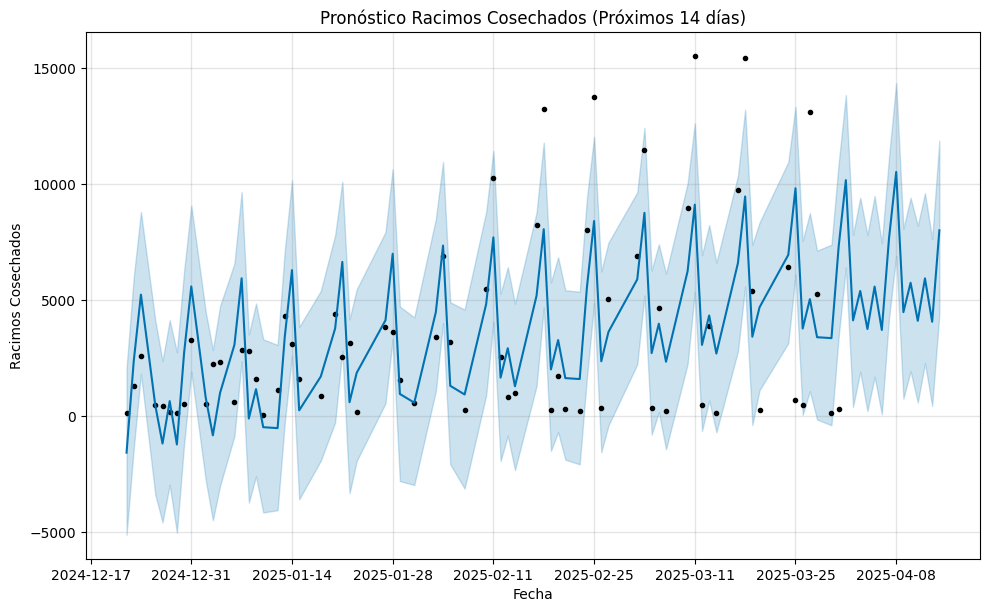

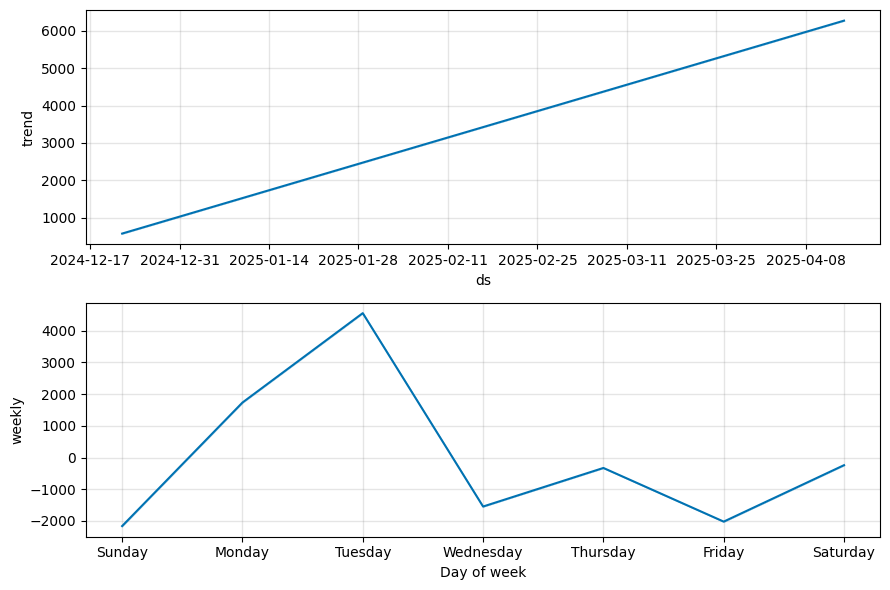


--- ¡IMPORTANTE! ---
Este es un modelo PROVISIONAL basado en datos históricos limitados.
 - Su precisión a largo plazo es incierta y probablemente baja.
 - No puede predecir con fiabilidad el inicio, fin o magnitud de futuros ciclos de actividad.
 - Es más útil para pronósticos a MUY CORTO PLAZO (pocos días a 1-2 semanas) asumiendo que los patrones recientes continúan.
 - Se requiere más histórico y posiblemente variables externas para un modelo robusto.


In [ ]:
from prophet import Prophet

from sklearn.metrics import mean_absolute_error



print("--- Implementando Estrategia Provisional con Prophet (Datos Diarios) ---")

# --- 1. Preparar Datos ---

print("\n1. Preparando datos para Prophet (Versión Concisa)...")

# --- Pasos combinados: Seleccionar, Convertir Tipos, Limpiar, Agregar y Renombrar ---
try:
    # Seleccionar, convertir, limpiar NaNs/NaTs iniciales
    df_prep = df_format[['fecha', 'racimos_cosechados']].copy()
    df_prep['fecha'] = pd.to_datetime(df_prep['fecha'], errors='coerce')
    df_prep['racimos_cosechados'] = pd.to_numeric(df_prep['racimos_cosechados'], errors='coerce')
    df_prep.dropna(subset=['fecha', 'racimos_cosechados'], inplace=True)

    # Agregar por día (sumar racimos) y renombrar para Prophet
    if not df_prep.empty:
        prophet_df = df_prep.groupby(df_prep['fecha'].dt.normalize())['racimos_cosechados'] \
                            .sum() \
                            .reset_index() \
                            .rename(columns={'fecha': 'ds', 'racimos_cosechados': 'y'})
        # Asegurar que 'ds' sea datetime (groupby puede devolver date)
        prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    else:
         prophet_df = pd.DataFrame(columns=['ds', 'y']) # Crear vacío si no hay datos

except KeyError as e:
    print(f"ERROR CRÍTICO: Columna requerida {e} no encontrada en df_format.")
    prophet_df = pd.DataFrame(columns=['ds', 'y']) # Crear df vacío para evitar más errores
except Exception as e:
     print(f"ERROR inesperado durante la preparación inicial: {e}")
     prophet_df = pd.DataFrame(columns=['ds', 'y'])

# --- Filtrado de Fechas Opcional ---
APLICAR_FILTRO_FECHA = True # Cambia a True para activar el filtro
if APLICAR_FILTRO_FECHA and not prophet_df.empty:
    print("   - Aplicando filtro de fechas...")
    start_date_filter = pd.to_datetime('2024-12-22')
    end_date_filter = pd.to_datetime('2025-03-31')
    prophet_df = prophet_df[
         (prophet_df['ds'] >= start_date_filter) &
         (prophet_df['ds'] <= end_date_filter)
    ].copy()

# --- Ordenamiento Final ---
if not prophet_df.empty:
    prophet_df.sort_values(by='ds', inplace=True)

# --- Resumen Final ---
if prophet_df.empty:
     print("\nADVERTENCIA: El DataFrame 'prophet_df' está vacío después de la preparación.")
     print("Verifique los datos originales y el filtro de fechas (si se usó).")
else:
     print("\n--- Datos Listos para Prophet (Paso 1 Completo) ---")
     print(f"DataFrame 'prophet_df' preparado con {len(prophet_df)} filas diarias.")
     print(f"Rango: {prophet_df['ds'].min().date()} a {prophet_df['ds'].max().date()}")
     print(prophet_df.head())

# --- 2. Preparar para Evaluación (Hold-Out Set Corto) ---
print("\n2. Preparando set de entrenamiento y prueba (hold-out)...")
# Definir cuántos días guardar para prueba

prediction_length = 7

if len(prophet_df) > prediction_length * 2: # Asegurar que quede suficiente para entrenar
    # Dividir los datos
    train_df = prophet_df[:-prediction_length]
    test_df = prophet_df[-prediction_length:]
    print(f"Entrenamiento: {len(train_df)} días, Prueba: {len(test_df)} días")
else:
    print(f"ADVERTENCIA: No hay suficientes datos para un hold-out de {prediction_length} días. Entrenando con todos los datos.")
    train_df = prophet_df.copy() # Entrenar con todo si no hay para dividir
    test_df = pd.DataFrame() # Test set vacío en este caso


# --- 3. Instanciar y Entrenar Modelo Prophet ---
print("\n3. Entrenando modelo Prophet...")
# Instanciar Prophet (configuración por defecto detecta estacionalidad semanal)
model = Prophet()
#  ej:
# model = Prophet(yearly_seasonality=False, daily_seasonality=False)
# Entrenar el modelo con los datos de entrenamiento
model.fit(train_df)
print("Modelo entrenado.")


# --- 4. Predecir en el Set de Prueba (si existe) ---
forecast_test = None
if not test_df.empty:
    print("\n4. Realizando predicciones en el set de prueba...")
    # Predecir usando las fechas del set de prueba
    forecast_test = model.predict(test_df[['ds']])
    print("Predicciones en set de prueba realizadas.")
    # Seleccionar columnas relevantes para la evaluación
    forecast_to_eval = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    # Unir con los valores reales para comparar
    eval_df = pd.merge(test_df, forecast_to_eval, on='ds')


# --- 5. Evaluar el Forecast (si hay set de prueba) ---
if forecast_test is not None and not eval_df.empty:
    print("\n5. Evaluando predicciones...")

    # --- 5.1 Visualización ---
    fig_eval = go.Figure()
    # Datos de entrenamiento
    fig_eval.add_trace(go.Scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='Entrenamiento (Real)'))
    # Datos de prueba (Reales)
    fig_eval.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['y'], mode='lines+markers', name='Prueba (Real)', line=dict(color='red')))
    # Predicción de Prophet
    fig_eval.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['yhat'], mode='lines', name='Prueba (Predicción Prophet)', line=dict(color='blue', dash='dash')))
    # Intervalos de confianza
    fig_eval.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['yhat_upper'], mode='lines', name='Intervalo Superior', line=dict(width=0), showlegend=False))
    fig_eval.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['yhat_lower'], mode='lines', name='Intervalo Inferior', line=dict(width=0), fill='tonexty', fillcolor='rgba(0,100,80,0.2)', showlegend=False))

    fig_eval.update_layout(title='Evaluación: Predicción Prophet vs Real (Hold-Out)',
                           xaxis_title='Fecha', yaxis_title='Racimos Cosechados')
    fig_eval.show()

    # --- 5.2 Métricas Cuantitativas ---
    mae_prophet = mean_absolute_error(eval_df['y'], eval_df['yhat'])
    print(f"  Error Absoluto Medio (MAE) de Prophet en set de prueba: {mae_prophet:.2f}")

    # --- 5.3 Comparación con Baseline (Seasonal Naive) ---
    # Crear predicción Naive: valor del mismo día de la semana pasada
    # Necesitamos datos históricos de al menos 7 días antes del set de prueba
    if len(train_df) >= 7:
        # Mapear las fechas de prueba a las fechas de hace 7 días
        test_dates_map = test_df['ds'] - pd.Timedelta(days=7)
        # Unir con el df de entrenamiento para obtener los valores de hace 7 días
        baseline_preds = pd.merge(pd.DataFrame({'ds_baseline': test_dates_map, 'ds': test_df['ds']}),
                                  train_df[['ds', 'y']],
                                  left_on='ds_baseline',
                                  right_on='ds',
                                  how='left')
        # Rellenar posibles NaNs si el día exacto no existía (poco probable con daily) con ffill o 0
        baseline_preds['y_baseline'] = baseline_preds['y'].fillna(0)

        # Calcular MAE del baseline (asegurándose que las longitudes coincidan)
        if len(baseline_preds) == len(eval_df):
             mae_baseline = mean_absolute_error(eval_df['y'], baseline_preds['y_baseline'])
             print(f"  Error Absoluto Medio (MAE) de Baseline (Seasonal Naive): {mae_baseline:.2f}")
             if mae_prophet < mae_baseline:
                 print("  -> Prophet superó al baseline simple.")
             else:
                 print("  -> Prophet NO superó al baseline simple.")
        else:
             print("  No se pudo calcular MAE del baseline (discrepancia de longitud).")

    else:
        print("  No hay suficientes datos históricos para calcular el baseline Seasonal Naive.")


# --- 6. Análisis de Residuales  ---
# Se haría sobre el set de entrenamiento para ver si el modelo capturó la estructura
# print("\n6. Analizando residuales del modelo en datos de entrenamiento...")
# train_forecast = model.predict(train_df[['ds']])
# train_residuals = train_df['y'] - train_forecast['yhat']
# fig_residuals = px.line(x=train_df['ds'], y=train_residuals, title='Residuales del Modelo Prophet (Entrenamiento)')
# fig_residuals.show()
#  añadir ACF/PACF de train_residuals con statsmodels


# --- 7. Hacer Pronóstico Futuro Real ---
print("\n7. Re-entrenando con TODOS los datos y generando pronóstico futuro...")
# Re-entrenar con todos los datos disponibles para el pronóstico final
model_final = Prophet()
model_final.fit(prophet_df) # Usar TODOS los datos

# Definir horizonte de pronóstico (ej. próximos 14 días)
future_periods = 14
# Crear DataFrame futuro
future_df = model_final.make_future_dataframe(periods=future_periods, freq='D')
# Realizar pronóstico
final_forecast = model_final.predict(future_df)

print(f"Pronóstico generado para los próximos {future_periods} días.")

# --- 8. Visualizar Pronóstico Final ---
print("\n8. Visualizando el pronóstico final...")
# Usar la función de plot de Prophet
fig_final = model_final.plot(final_forecast)
plt.title(f'Pronóstico Racimos Cosechados (Próximos {future_periods} días)')
plt.xlabel('Fecha')
plt.ylabel('Racimos Cosechados')
plt.show()

# Opcional: Plot de componentes (tendencia, estacionalidad)
fig_components = model_final.plot_components(final_forecast)
plt.show()


# --- 9. Limitaciones ---
print("\n--- ¡IMPORTANTE! ---")
print("Este es un modelo PROVISIONAL basado en datos históricos limitados.")
print(" - Su precisión a largo plazo es incierta y probablemente baja.")
print(" - No puede predecir con fiabilidad el inicio, fin o magnitud de futuros ciclos de actividad.")
print(" - Es más útil para pronósticos a MUY CORTO PLAZO (pocos días a 1-2 semanas) asumiendo que los patrones recientes continúan.")
print(" - Se requiere más histórico y posiblemente variables externas para un modelo robusto.")